# Training of proposed neural netork

In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize

import matplotlib.animation as animation
%matplotlib notebook

In [8]:
plt.rcParams['figure.figsize'] = [12,8]

## Training data created using this file

[Google drive link](https://drive.google.com/drive/folders/1122Cp2U_4hX5YMuVd4aA-cu4odz4OV9O?usp=sharing)

## How to work with this file? 
This file has to be put into COVID-19 respository by hand root/Train directory.
Then dwonload specific [CT dataset](https://github.com/mr7495/COVID-CTset). This file worked with COVID-CTset_part1/COVID+ patients, but with minor changes it can be changed.

## Plan of work

- ### 1. Creating training data 

    Our classifier that we want to train uses zoomed lung data, but what we have is raw data. We have to use other NN to create a mask for each patient that we will use to transform the raw CT scans into format that can be used for training. Transformed data should be stored for later use
    
- ### 2. Training 
    
    Authors thankfuly saved weights of pretrained nn. We will use this as a base and either just run it on new data or we will fine tune this nn. It's not sure now what will work and to what degree are we able to train this large nn. For now it would be great to firstly load our nn and then run it on a datum, then try to train it on a small batch of data.

## Quick look into data

**Side note** Some cells at the beging return erors becouse they operate on data that had to be removed due to no space left on discs. If one will follow every step mentioned in description above no errors should occur.

In [3]:
path_to_data = "../Data/COVID-CTset part1/"

In [4]:
im = Image.open(path_to_data+"COVID19+/covid1/patient11/+/IM00001.tif")
im.size

FileNotFoundError: [Errno 2] No such file or directory: '../Data/COVID-CTset part1/COVID19+/covid1/patient11/+/IM00001.tif'

In [ ]:
im_array = np.array(im)

In [5]:
plt.imshow(im_array)

NameError: name 'im_array' is not defined

<IPython.core.display.Javascript object>


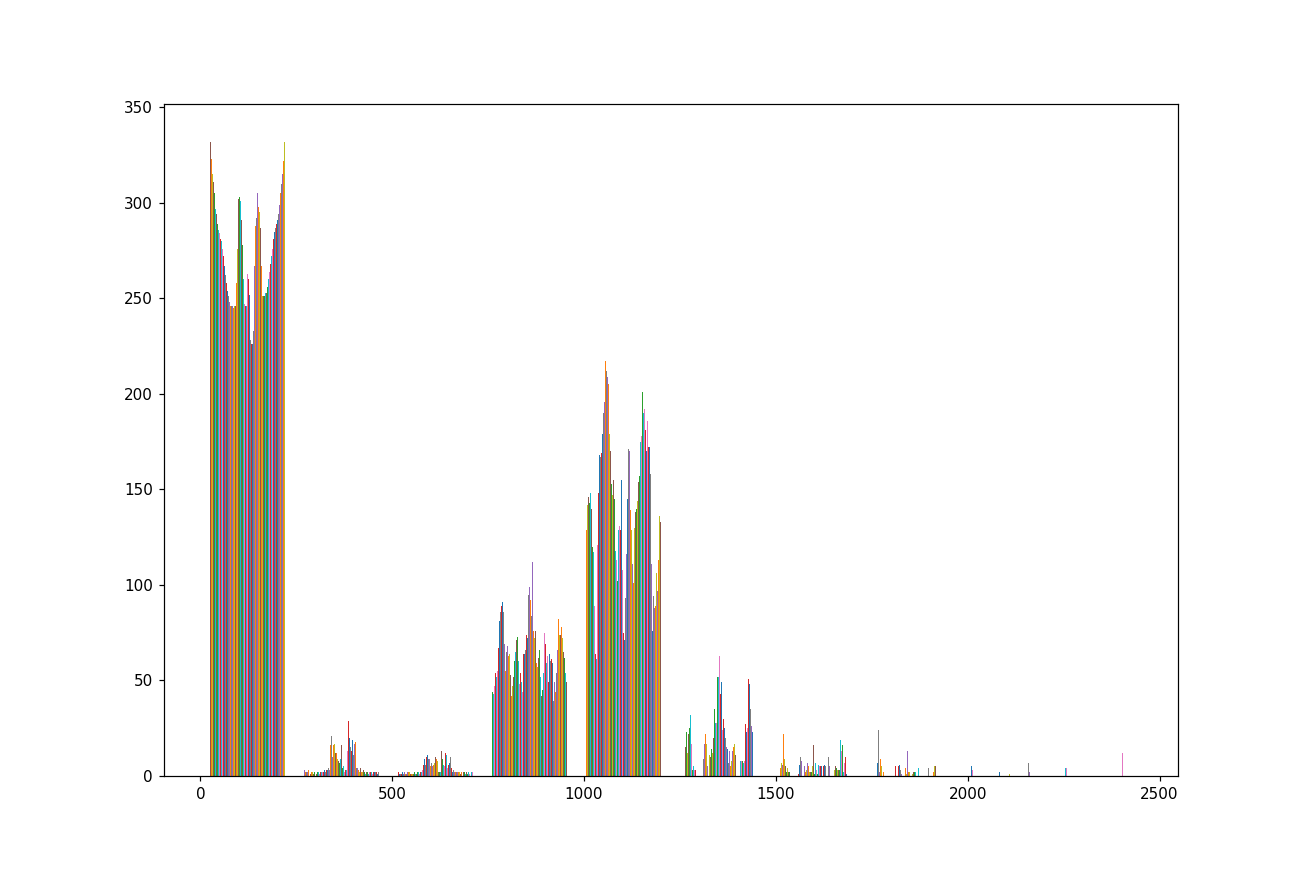

(array([[335.,   3.,   2., ...,   0.,   0.,   0.],
        [335.,   2.,   1., ...,   0.,   0.,   0.],
        [334.,   2.,   2., ...,   0.,   0.,   0.],
        ...,
        [332.,   2.,   1., ...,   0.,   0.,   0.],
        [333.,   2.,   2., ...,   0.,   0.,   0.],
        [334.,   2.,   2., ...,   0.,   0.,   0.]]),
 array([   0. ,  245.3,  490.6,  735.9,  981.2, 1226.5, 1471.8, 1717.1,
        1962.4, 2207.7, 2453. ]),
 <a list of 512 BarContainer objects>)

In [13]:
plt.hist(im_array)

## Creating training data

In [9]:
import os
import scipy.io

In [10]:
"""
    Creates and returns a 3d tensor of a CT scan with 3 dimension being depth of the image
"""
def create_CT_model(dir_path):
    files = os.listdir(dir_path)
    model_3d = np.zeros((512,512,len(files)))
    
    for i,file in enumerate(files):
        im = Image.open(dir_path+file)        
        model_3d[:,:,-(i+1)] = np.array(im)
    return model_3d

### Transforming selected batch of data

In [11]:
path_to_batch = "../Data/COVID-CTset part1/NORMAL/normal2/"
test_result = "-" 

In [12]:
## For each patient 
for file in tqdm(os.listdir(path_to_batch)):

    full_path = path_to_batch+"/"+file+"/"+test_result+"/"
    
    try: 
        
        os.mkdir(f"../Data/Unused/{file}_{test_result}")
        
        ## Create 3d model
        model = create_CT_model(full_path)

        ## Save model to mat file
        mat_data = {"label":"Created CT model","new_img": model}
        scipy.io.savemat(f"../Data/Unused/{file}_{test_result}/{file}_{test_result}.mat",mat_data)
    except FileExistsError:
        continue

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: '../Data/COVID-CTset part1/NORMAL/normal2/'

## Let's see our results

In [13]:
def create_animation(data, interval = 150, show = True, filename = None):
    fig = plt.figure( figsize=(8,8) )
    init_frame = data[:,:,0]
    im = plt.imshow(init_frame, interpolation='none', aspect='auto')

    def animate_func(i):
        im.set_array(data[:,:,i])
        return [im]

    frames = data.shape[2]
    
    anim = animation.FuncAnimation(fig, animate_func, frames = frames,interval = interval, blit = True)    
    return anim

In [29]:
model = create_CT_model("../Data/COVID-CTset part1/COVID19+/covid1/patient11/+/")

<IPython.core.display.Javascript object>


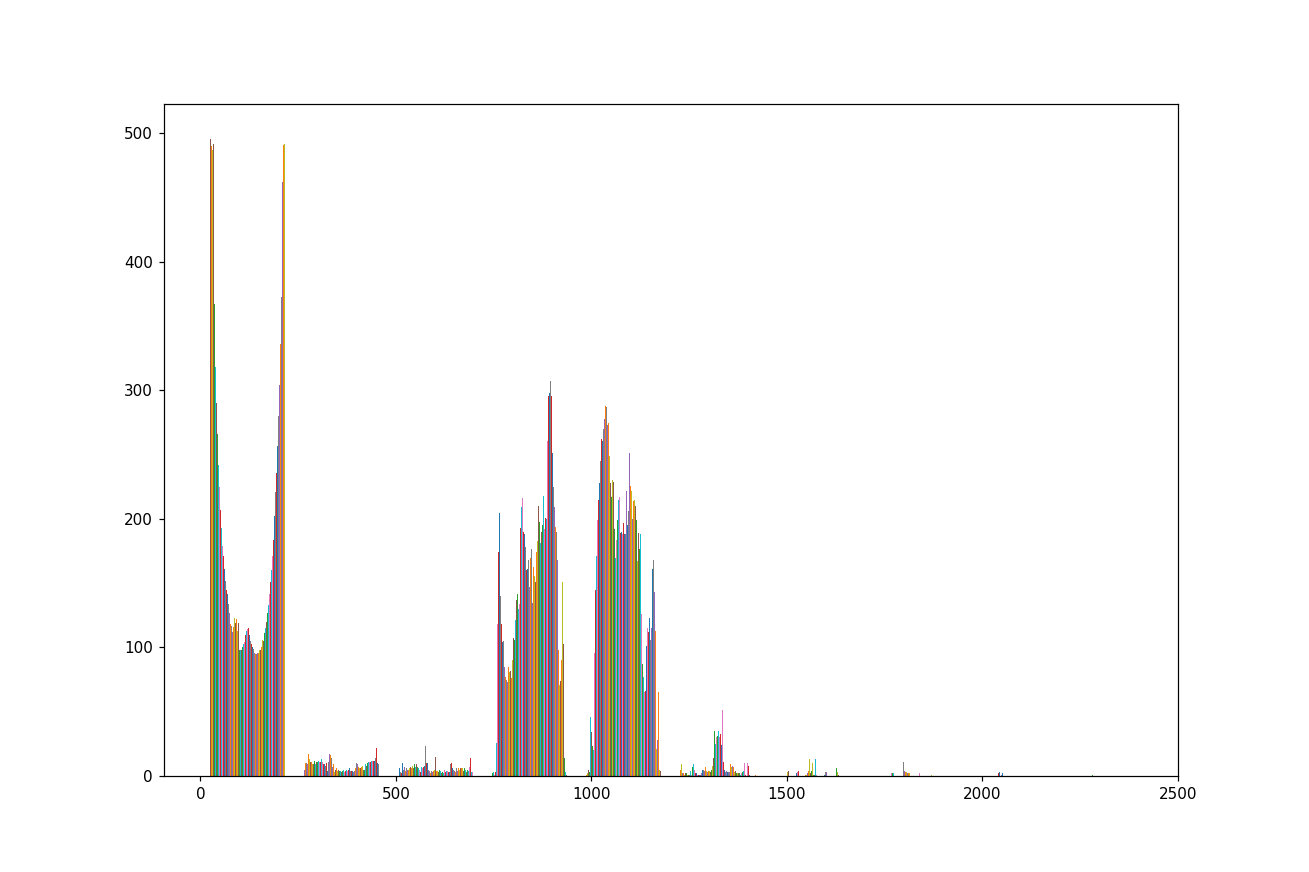

(array([[497.,   5.,   2., ...,   0.,   0.,   0.],
        [498.,   4.,   2., ...,   0.,   0.,   0.],
        [497.,   5.,   1., ...,   0.,   0.,   0.],
        ...,
        [491.,  11.,   2., ...,   0.,   0.,   0.],
        [492.,  10.,   3., ...,   0.,   0.,   0.],
        [490.,  12.,   1., ...,   0.,   0.,   0.]]),
 array([   0. ,  240.7,  481.4,  722.1,  962.8, 1203.5, 1444.2, 1684.9,
        1925.6, 2166.3, 2407. ]),
 <a list of 512 BarContainer objects>)

In [30]:
plt.hist(model[:,:,0])

<IPython.core.display.Javascript object>


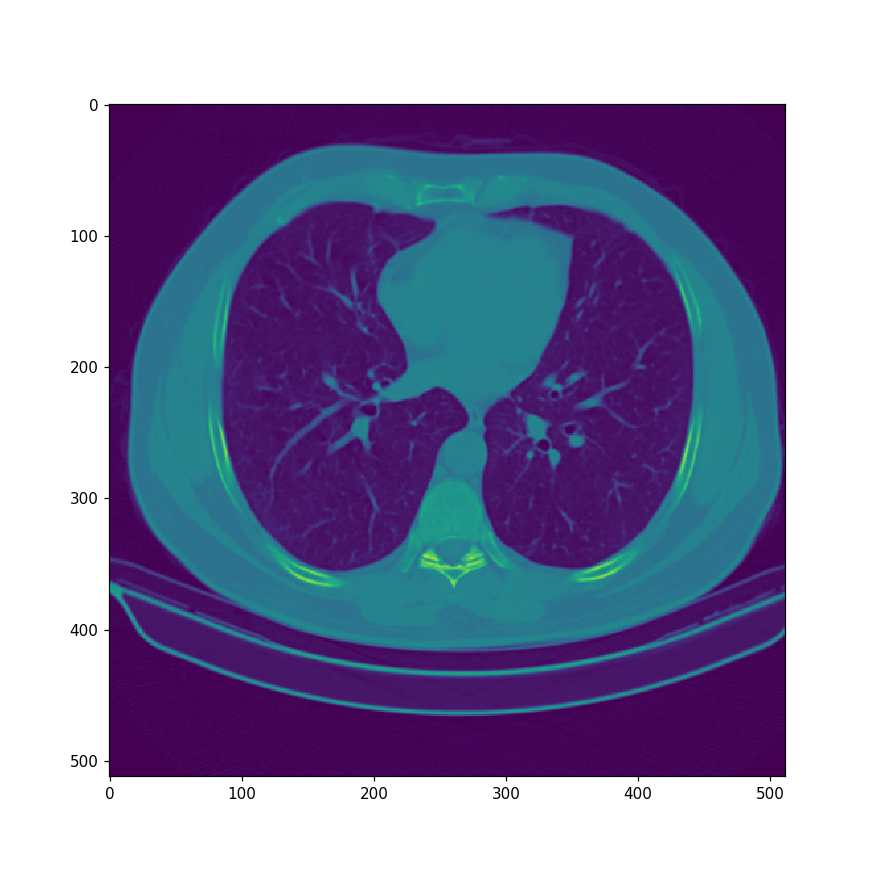

In [31]:
create_animation(model)

In [33]:
CT_model = scipy.io.loadmat("../Data/Unused/patient13_+/patient13_+.mat")

<IPython.core.display.Javascript object>


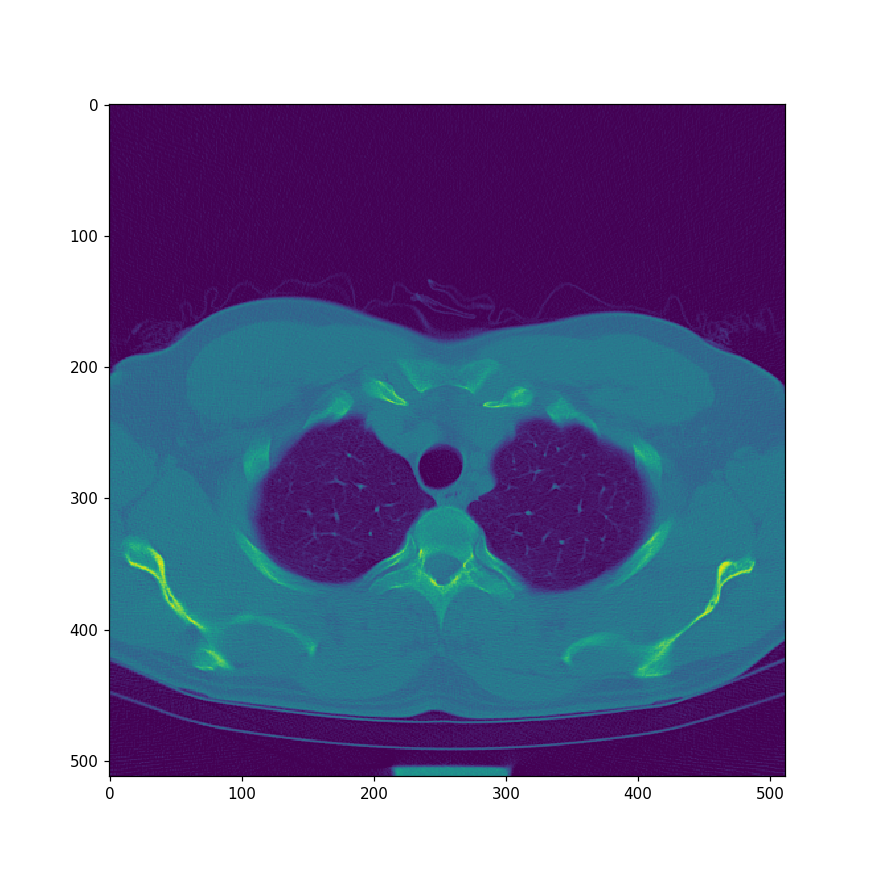

In [34]:
create_animation(CT_model['new_img'])

## Creating masks

The easiest way is to do it is to run a command in a terminal, because all nescessary features are implemented in a 
python class in a different directory. To create mask for this batch I run this command

`python lungSegNet4seg19Conv.py dataset=../../Data/Training nonLungAreaSuppression=true gpu=0  multiprocess=0/1`

This should create masks only if there is none currently for given patient. If the patient data changes mask has to be deleted and then build by command in order for it to contain changes. Also raw scans have to have the same name as the directory.
### Let's inspect created masks

In [35]:
CT_model_mask = scipy.io.loadmat("../Data/Unused/patient1_+/patient1_+_lungMask.mat")

<IPython.core.display.Javascript object>


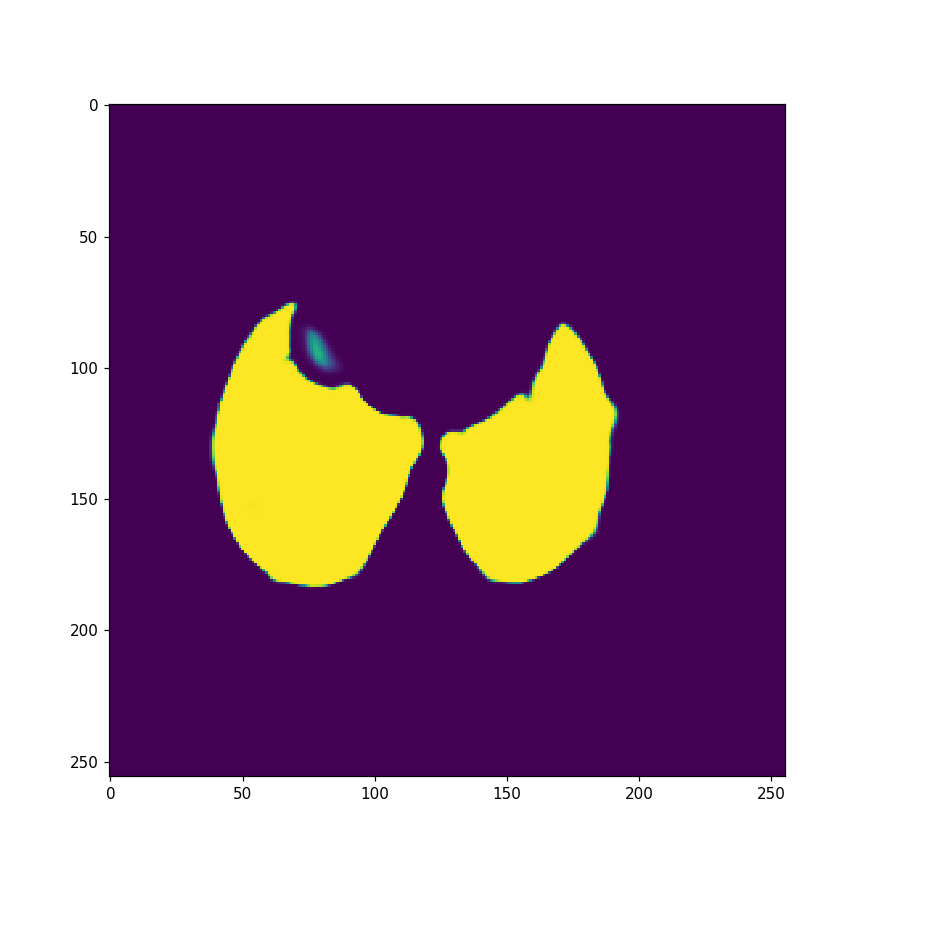

In [36]:
create_animation(CT_model_mask['lung_mask'])

## Last step. Creating zoomed scans

This is by far the hardest and the weirdest part, because our squared scans with different amounts of layers is resized into fixed 360x240x48 shape. There is no information how authors did this zooming, and what to do if our scan has less or more than 48 layers. This means that we will have to experiment and improvise in hope that our changes won't affect training process much, but nevertheless they surely will. 

#### Apllying the mask.
This is still easy

In [37]:
def apply_mask(model, mask):
    # threshold was found by trail and error
    return np.where(mask>8e-5, model, 0)

In [38]:
path_to_scans = "../Data/Unused/"
CT_model_path = path_to_scans+"patient1_+/patient1_+"

CT_model = scipy.io.loadmat(CT_model_path+".mat")
## Load model mask
CT_model_mask = scipy.io.loadmat(CT_model_path+"_lungMask.mat")
CT_model_mask = np.repeat(np.repeat(CT_model_mask["lung_mask"], 2, axis=0), 2, axis=1)

In [39]:
CT_model_mask.shape

(512, 512, 33)

For some reason mask allways cuts out first and last frame

In [40]:
CT_model['new_img'][:,:,1:-1].shape

(512, 512, 33)

In [41]:
new_model = apply_mask(CT_model['new_img'][:,:,1:-1],CT_model_mask)

<IPython.core.display.Javascript object>


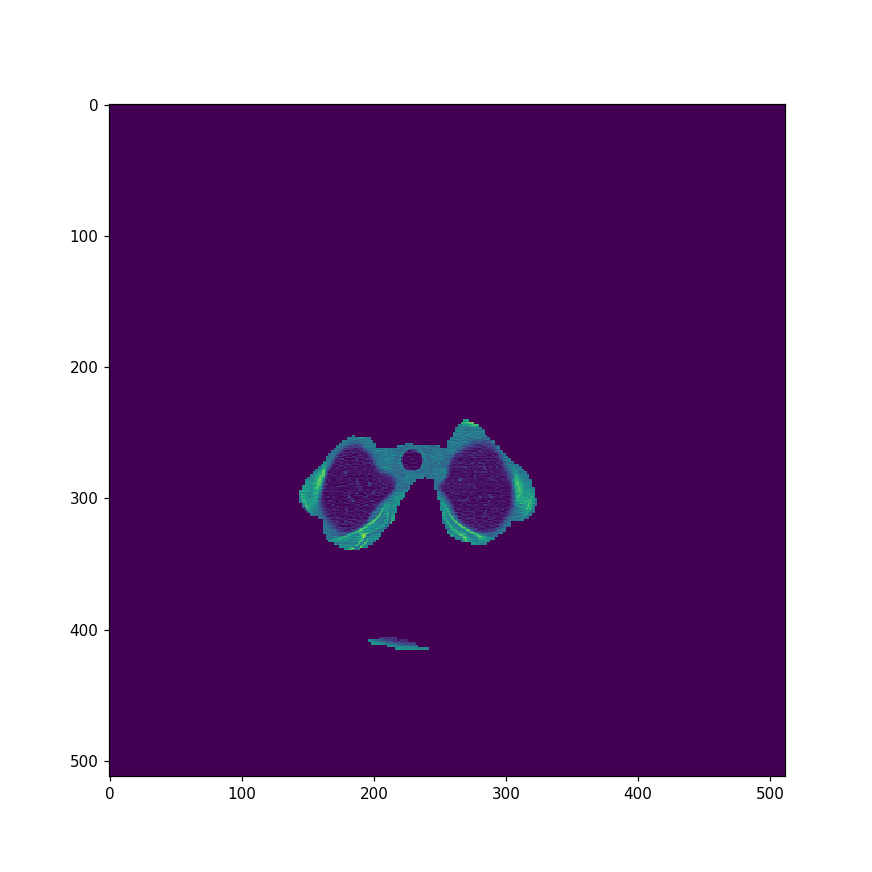

In [42]:
create_animation(new_model)

This is worse than the result that authors got, but for now is acceptable.

## Resizing scans

For simplicity in our first attemt we will be cutting the scan in fixed region. We hope that CT scans are simmilar enough, so this can generalize well on all scans. We assume, but don't really know.

<IPython.core.display.Javascript object>


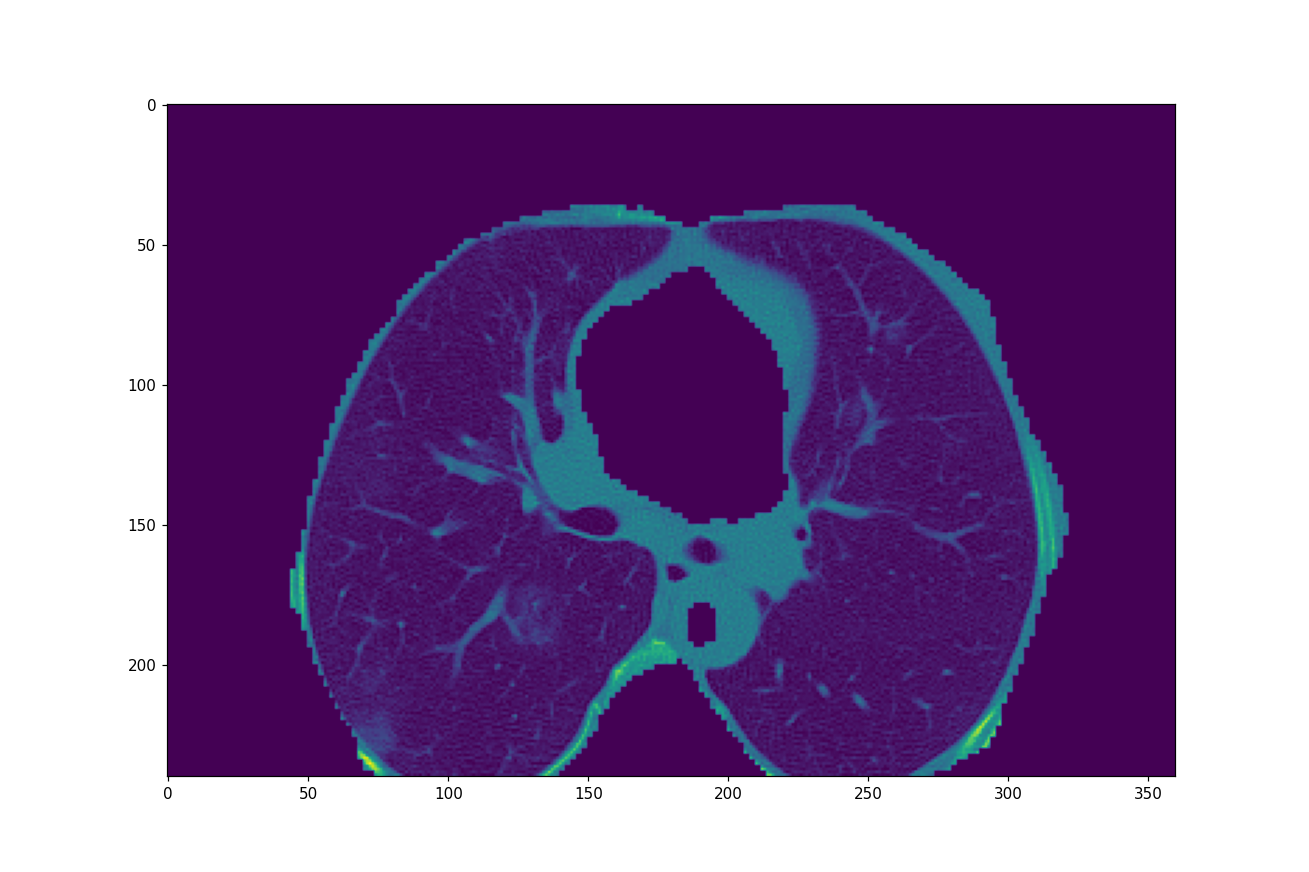

In [43]:
plt.imshow(new_model[120:360,50:410,20])

<IPython.core.display.Javascript object>


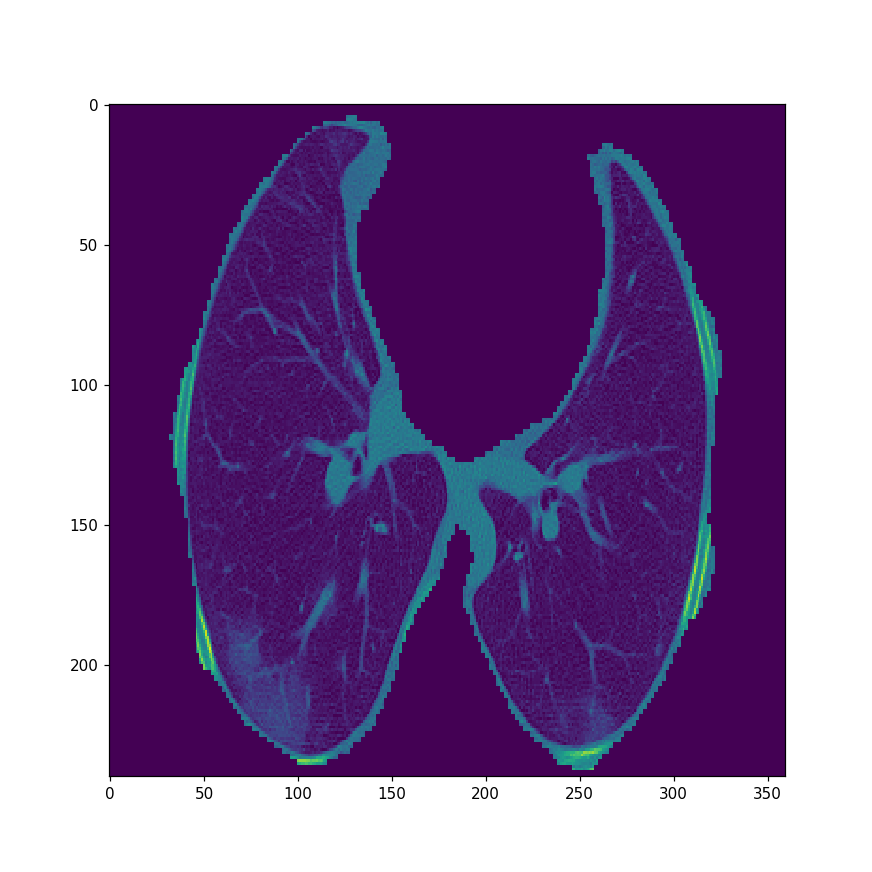

In [44]:
create_animation(new_model[140:380,50:410,:])

This seems about right 

In [45]:
zoomed_model = new_model[140:380,50:410,:]

Bu the max values are higher than 1024 used by te moodel so we will scale it down 

In [63]:
np.max(zoomed_model)

2731.0

In [62]:
np.min(zoomed_model)

0.0

In [102]:
normalized_model  = np.rint(zoomed_model / np.max(np.abs(zoomed_model))*1024)

<IPython.core.display.Javascript object>


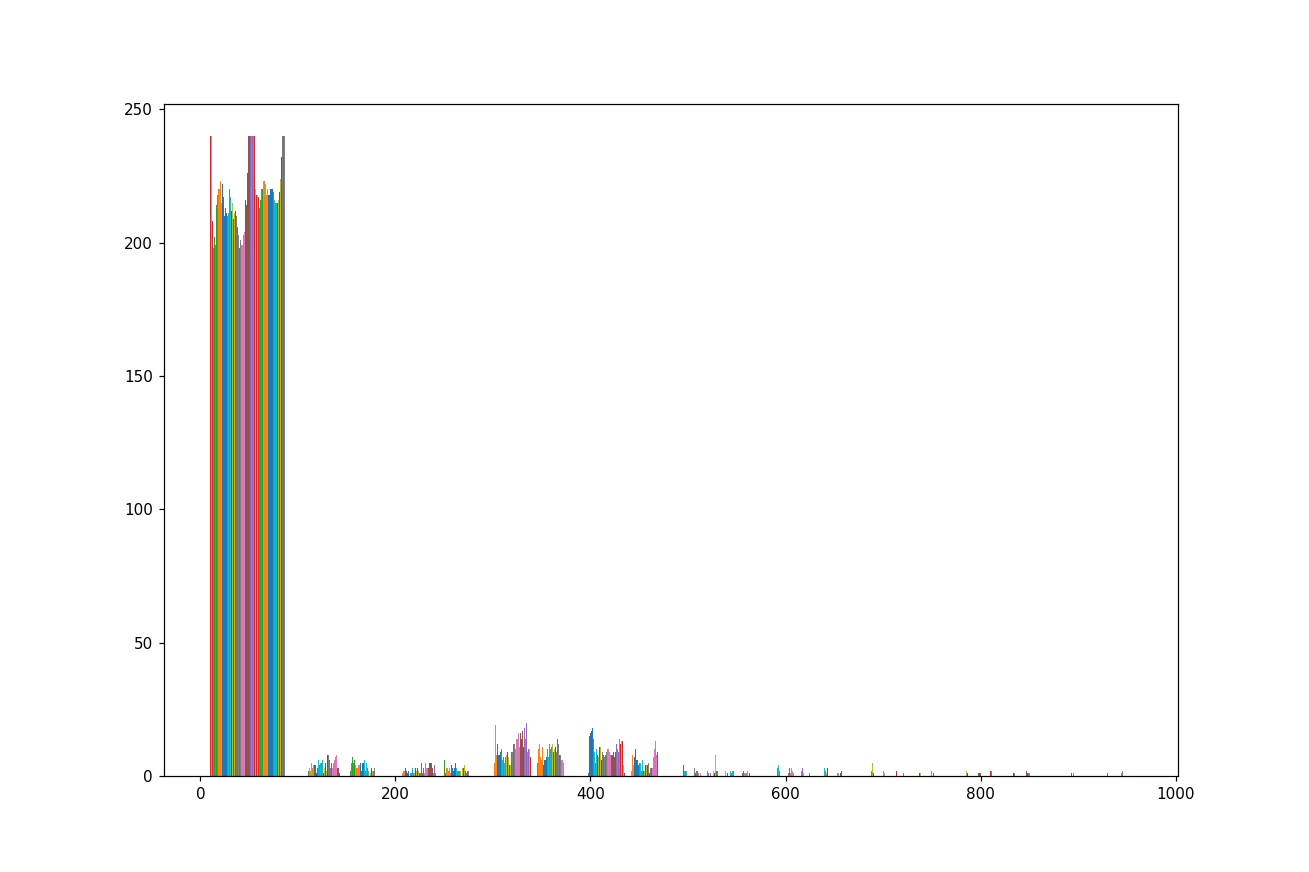

(array([[240.,   0.,   0., ...,   0.,   0.,   0.],
        [240.,   0.,   0., ...,   0.,   0.,   0.],
        [240.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [240.,   0.,   0., ...,   0.,   0.,   0.],
        [240.,   0.,   0., ...,   0.,   0.,   0.],
        [240.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0. ,  96.5, 193. , 289.5, 386. , 482.5, 579. , 675.5, 772. ,
        868.5, 965. ]),
 <a list of 360 BarContainer objects>)

In [101]:
plt.hist(normalized_model[:,:,0])

lastly we need exactly 48 layers

In [103]:
normalized_model.shape

(240, 360, 33)

So we are missing 15. Great. We have to remember that usually we will be missing layer but sometimes we will have too many,so we have to fix those two problems.

In [47]:
def fix_layers(model):
    n = model.shape[2]
    
    if n==48:
        # wow  great luck
        return model
    elif n<48:
        diff = 48-n
        return np.append(np.zeros((240,360,diff)),model, axis=2)
    else:
        # too many layers, keep the middle 
        diff = n-48
        if diff%2==0:
            return model[:,:,int(diff//2):int(n-diff//2)]
        return model[:,:,int(diff//2)+1:int(n-diff//2)]

In [104]:
finished_model = fix_layers(normalized_model)

In [105]:
finished_model.shape

(240, 360, 48)

Wonderful. Lets look one more time at what we had and what we have at the end of this process

<IPython.core.display.Javascript object>


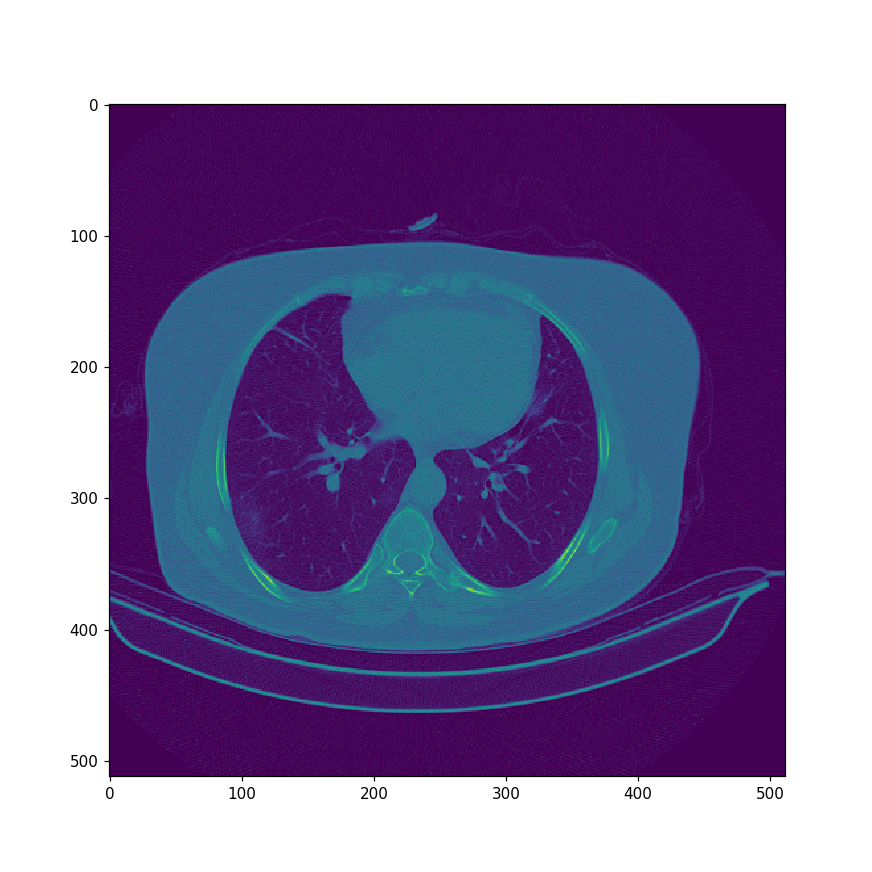

In [50]:
create_animation(CT_model['new_img'])

<IPython.core.display.Javascript object>


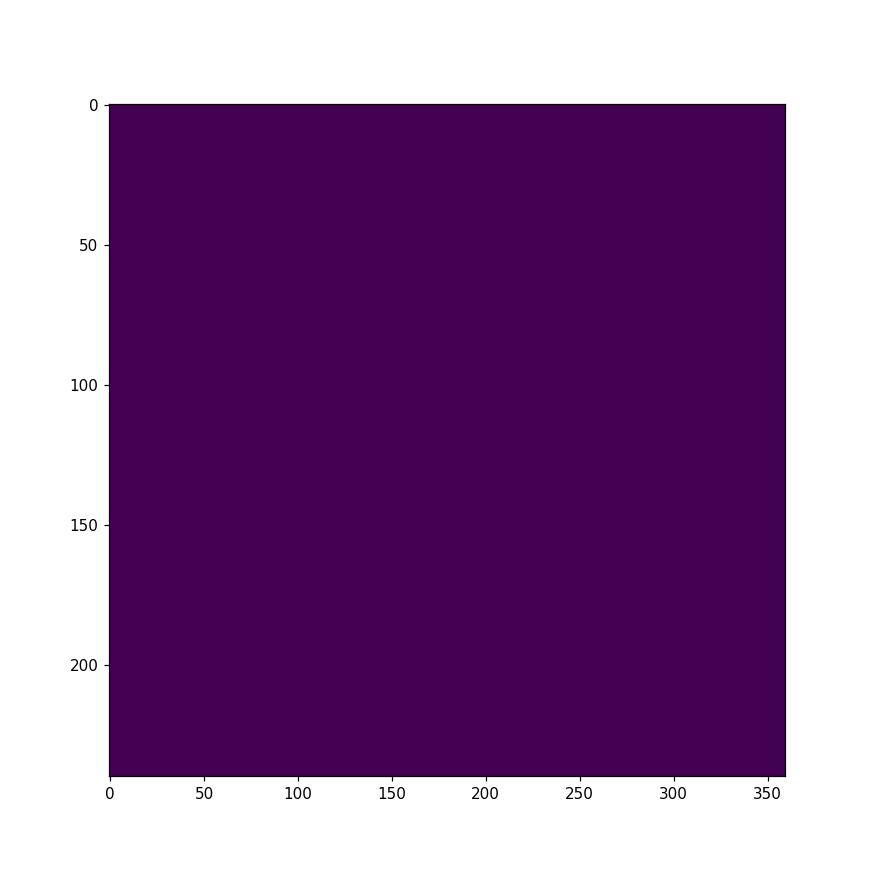

In [51]:
create_animation(finished_model)

Let's perform all of this steps for CT of every patient

In [107]:
path_to_scans = "../Data/Unused/"
## For each scan 
for file in tqdm(os.listdir(path_to_scans)):

    CT_model_path = path_to_scans+file+"/"+file
    
    ## Load oryginal model
    CT_model = scipy.io.loadmat(CT_model_path+".mat")
    ## Load model mask
    CT_model_mask = scipy.io.loadmat(CT_model_path+"_lungMask.mat")
    CT_model_mask = np.repeat(np.repeat(CT_model_mask["lung_mask"], 2, axis=0), 2, axis=1)
    
    new_CT_model = apply_mask(CT_model['new_img'][:,:,1:-1],CT_model_mask)
    
    reshaped_model = new_CT_model[140:380,50:410,:] 
    
    normalized_model  = np.rint(reshaped_model / np.max(np.abs(reshaped_model))*1024)
    
    finished_model = fix_layers(normalized_model)
    
    ## save model
    
    data = {"type": "Zoomed CT scan", "only_lung_zoomed_3std": finished_model}
    
    CT_model_mask = scipy.io.savemat(CT_model_path+"_onlyLungZoomed3std.mat",data)
    

  0%|          | 0/173 [00:00<?, ?it/s]

### Creating training, validation and test datasets

In [36]:
path_to_scans = "../Data/Unused/"

positive = []
negative = []
## For each scan 
for file in tqdm(os.listdir(path_to_scans)):
    _,test_result = file.split("_")
    
    if test_result == "+":
        positive.append(f"{file}/{file}_onlyLungZoomed3std.mat")
    else:
        negative.append(f"{file}/{file}_onlyLungZoomed3std.mat")



  0%|          | 0/173 [00:00<?, ?it/s]

In [56]:
def create_datasets(positive, negative, validation = 0.1, test = 0.2, main_dir = "../Data/", path_to_scans = "../Data/Unused/"):
    
    n_pos = len(positive)
    n_neg = len(negative)
    
    
    for dataset in ["validation","test","training"]:
        if dataset =="validation":
            proc = validation
        elif dataset =="test":
            proc = test
        else:
            proc = 1 - validation - test
        
        np.savetxt(f"{main_dir}{dataset}.csv", np.r_[positive[:int(n_pos*proc)],negative[:int(n_neg*proc)]], newline=",\n", fmt='%s')

        for file in positive[:int(n_pos*proc)]:
            try:
                _dir,_ = file.split("/")
                os.mkdir(f"{main_dir}{dataset}/{_dir}")
                os.rename(f"{path_to_scans}{file}",f"{main_dir}{dataset}/{file}")
            except FileExistsError:
                continue
        for file in negative[:int(n_neg*proc)]:
            try:
                _dir,_ = file.split("/")
                os.mkdir(f"{main_dir}{dataset}/{_dir}")
                os.rename(f"{path_to_scans}{file}",f"{main_dir}{dataset}/{file}")
            except FileExistsError:
                continue

        positive = positive[int(n_pos*proc):]
        negative = negative[int(n_neg*proc):]

In [57]:
create_datasets(positive,negative)

In [53]:
np.r_[positive[:10],negative[:10]]

array(['patient137_+/patient137_+_onlyLungZoomed3std.mat',
       'patient138_+/patient138_+_onlyLungZoomed3std.mat',
       'patient139_+/patient139_+_onlyLungZoomed3std.mat',
       'patient13_+/patient13_+_onlyLungZoomed3std.mat',
       'patient140_+/patient140_+_onlyLungZoomed3std.mat',
       'patient141_+/patient141_+_onlyLungZoomed3std.mat',
       'patient142_+/patient142_+_onlyLungZoomed3std.mat',
       'patient144_+/patient144_+_onlyLungZoomed3std.mat',
       'patient145_+/patient145_+_onlyLungZoomed3std.mat',
       'patient15_+/patient15_+_onlyLungZoomed3std.mat',
       'patient281_-/patient281_-_onlyLungZoomed3std.mat',
       'patient282_-/patient282_-_onlyLungZoomed3std.mat',
       'patient283_-/patient283_-_onlyLungZoomed3std.mat',
       'patient284_-/patient284_-_onlyLungZoomed3std.mat',
       'patient285_-/patient285_-_onlyLungZoomed3std.mat',
       'patient286_-/patient286_-_onlyLungZoomed3std.mat',
       'patient287_-/patient287_-_onlyLungZoomed3std.mat',
 

In [46]:
np.savetxt("file_name.csv", positive, newline=",", fmt='%s')

### Creating validation dataset

In [37]:
path_to_validation_dataset = "../Data/Validation/"
validation = 5

with open("../Data/validation.csv","a+") as file:
    file.writelines(positive[:validation])
    file.writelines(negative[:validation])

for file in positive[:validation]:
    try:
        _dir,_ = file.split("/")
        os.mkdir(f"{path_to_validation_dataset}{_dir}")
        os.rename(f"{path_to_scans}{file}",f"{path_to_validation_dataset}{file}")
    except FileExistsError:
        continue
for file in negative[:validation]:
    try:
        _dir,_ = file.split("/")
        os.mkdir(f"{path_to_validation_dataset}{_dir}")
        os.rename(f"{path_to_scans}{file}",f"{path_to_validation_dataset}{file}")
    except FileExistsError:
        continue
    
positive = positive[validation:]
negative = negative[validation:]

### Creating test dataset

In [39]:
path_to_test_dataset = "../Data/Test/"
test = 20

with open("../Data/test.csv","a+") as file:
    file.writelines(positive[:test])
    file.writelines(negative[:test])

for file in positive[:test]:
    try:
        _dir,_ = file.split("/")
        os.mkdir(f"{path_to_test_dataset}{_dir}")
        os.rename(f"{path_to_scans}{file}",f"{path_to_validation_dataset}{file}")
    except FileExistsError:
        continue
    
for file in negative[:test]:
    try:
        _dir,_ = file.split("/")
        os.mkdir(f"{path_to_test_dataset}{_dir}")
        os.rename(f"{path_to_scans}{file}",f"{path_to_validation_dataset}{file}")
    except FileExistsError:
        continue
    
    
positive = positive[test:]
negative = negative[test:]

### Creating training dataset

In [40]:
path_to_training_dataset = "../Data/Training/"

with open("../Data/training.csv","a+") as file:
    file.writelines(positive)
    file.writelines(negative)

for file in positive:
    try:
        _dir,_ = file.split("/")
        os.mkdir(f"{path_to_training_dataset}{_dir}")
        os.rename(f"{path_to_scans}{file}",f"{path_to_validation_dataset}{file}")
    except FileExistsError:
        continue
    
for file in negative:
    try:
        _dir,_ = file.split("/")
        os.mkdir(f"{path_to_training_dataset}{_dir}")
        os.rename(f"{path_to_scans}{file}",f"{path_to_validation_dataset}{file}")
    except FileExistsError:
        continue

## Summary of creating training data

After executing last cell we should have a training data folder with patients. For every patient 3 .mat files should exist. Raw CT scan, mask, and zoomed CT scan that is ready to be used by our classifier. If that's true, we can proceed, to the next step.

## Training classifier
This part was done in different file 'trenowanie.py' which has some requirements to work. First of all it has to be put inside COVID-19/ERSCOVIDTest/COVID-19/ folder. Also it requires data, created in previous part of this file, can be also found [here](https://drive.google.com/drive/folders/1122Cp2U_4hX5YMuVd4aA-cu4odz4OV9O?usp=sharing). Such dataset should be renamed from now defult "Data" to "dataset" and put in the same directory as 'testowanie.py'

Keep in mind that training process might be impossible to perform on machines with weaker GPUs